In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
from scipy import stats
import os

from scipy import spatial
from scipy import sparse
from scipy.interpolate import CubicSpline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from umap import UMAP
from scipy.stats import zscore

import json

In [2]:
import importlib

from scroutines import powerplots
from scroutines.miscu import is_in_polygon

import utils_merfish
importlib.reload(utils_merfish)
from utils_merfish import rot2d, st_scatter, st_scatter_ax, plot_cluster, binning
from utils_merfish import RefLineSegs

import merfish_datasets
import merfish_genesets
importlib.reload(merfish_datasets)
from merfish_datasets import merfish_datasets
from merfish_datasets import merfish_datasets_params

from scroutines import basicu

In [3]:
def get_qc_metrics(df):
    """
    return metrics
     - key
      - (name, val, medval, bins)
    """
    metrics = {}
    cols  = ['volume', 'gncov', 'gnnum']
    names = ['cell volume', 'num transcripts', 'num genes']
    
    for col, name in zip(cols, names):
        val = df[col].values
        medval = np.median(val)
        bins = np.linspace(0, 10*medval, 50)
        
        metrics[col] = (name, val, medval, bins)
    return metrics

def get_norm_counts(adata, scaling=500):
    """norm - equalize the volume to be 500 for all cells
    """
    cnts = adata.X
    vol = adata.obs['volume'].values
    normcnts = cnts/vol.reshape(-1,1)*scaling
    adata.layers['norm'] = normcnts
    
    return normcnts

In [4]:
def add_triangle(XC, ax, zorder=0, vertices=False, **kwargs):
    # add the triangle
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--',  color='gray', label='', zorder=zorder, linewidth=1, markersize=3)
    
    # add vertices
    if vertices:
        ax.scatter(XC[0,0], XC[1,0], color='C0', zorder=zorder, **kwargs)
        ax.scatter(XC[0,1], XC[1,1], color='C1', zorder=zorder, **kwargs)
        ax.scatter(XC[0,2], XC[1,2], color='C2', zorder=zorder, **kwargs)

In [5]:
def binning_pipe(adata, n=20, layer='lnorm', bin_type='depth_bin'):
    """
    """
    assert bin_type in ['depth_bin', 'width_bin']
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_['width_bin'] = width_binned
    
    norm_mean = norm_.groupby(bin_type).mean(numeric_only=True)
    norm_sem  = norm_.groupby(bin_type).sem(numeric_only=True)
    norm_std  = norm_.groupby(bin_type).std(numeric_only=True)
    norm_n    = norm_[bin_type].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins

def binning_pipe2(adata, col_to_bin, layer, bins=None, n=20):
    """
    """
    if bins is None:
        # bin it 
        bins, binned = utils_merfish.binning(adata.obs[col_to_bin].values, n)
    else:
        binned = pd.cut(adata.obs[col_to_bin].values, bins=bins)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['thebin'] = binned
    
    norm_mean = norm_.groupby('thebin').mean(numeric_only=True)
    norm_sem  = norm_.groupby('thebin').sem(numeric_only=True)
    norm_std  = norm_.groupby('thebin').std(numeric_only=True)
    norm_n    = norm_['thebin'].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, binned, bins 

In [6]:
np.random.seed(0)

In [7]:
ddir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized" 
fin = os.path.join(ddir, 'P28NRDR_v1glut_rna_merfish_240729.h5ad')
# !ls $ddir/*l2*240723.h5ad 

In [8]:
adata_merge = ad.read(fin)
adata_snrnasq = adata_merge[adata_merge.obs['modality']=='rna']
adata_merfish = adata_merge[adata_merge.obs['modality']=='merfish'] 

adata_merge, adata_snrnasq, adata_merfish

(AnnData object with n_obs × n_vars = 36376 × 361
     obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass', 'modality', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'blended_domains', 'x2', 'y2', 'depth', 'width', 'norm_transcript_count', 'jnorm_transcript_count', 'depth_show', 'width_show', 'leiden_r0.3', 'umap1', 'umap2', 'umap1_self', 'umap2_self', 'max_pred', 'frac_self_neighbors', 'gated_pred', 'max_pred_subclass', 'frac_self_neighbors_subclass', 'gated_pred_subclass'
     uns: 'neighbors', 'umap'
     obsm: 'X_pca', 'X_pca2', 'X_pca_harmony', 'X_umap', 'X_xy', 'blanks', 'pca', 'umap'
     layers: 'jnorm', 'ljnorm', 'lognorm', 'norm'
     obsp: 'con

In [9]:
%%time
names = [
    'P28NRa_ant', 
    'P28NRa_pos',
    
    'P28NRb_ant', 
    'P28NRb_pos',
    
    'P28DRa_ant', 
    'P28DRa_pos',
    
    'P28DRb_ant', 
    'P28DRb_pos',
]

alldata = {}
for name in names:
    adatasub = ad.read(os.path.join(ddir, f'{name}_l2_v1_240723.h5ad')) 
    adatasub.obs.index = np.char.add(f'{name}', adatasub.obs.index.values)
    alldata[name] = adatasub 
    print(name, len(alldata[name]))
    
genes = adatasub.var.index.values
genes.shape

P28NRa_ant 4875
P28NRa_pos 9816
P28NRb_ant 2984
P28NRb_pos 12329
P28DRa_ant 5986
P28DRa_pos 7733
P28DRb_ant 10244
P28DRb_pos 8207
CPU times: user 738 ms, sys: 924 ms, total: 1.66 s
Wall time: 10.1 s


(500,)

In [10]:
genesets, df = merfish_genesets.get_all_genesets()
for key, item in genesets.items():
    print(key, len(item))

a 64
b 35
c 71
i 16
a_up 14


In [11]:
agenes = genesets['a']
bgenes = genesets['b']
cgenes = genesets['c']
iegs   = genesets['i']
abcgenes = np.hstack([agenes, bgenes, cgenes])
genes_noniegs = np.array([g for g in genes if g not in iegs])

marker_genes = [
       'Ptprn', 'Slc17a7', 'Gad1', 'Fos', 
       
       'Gfap', 'Slc6a13', 'Slc47a1',
       'Grin2c', 'Aqp4', 'Rfx4', 'Sox21', 'Slc1a3',
       
       'Sox10', 'Pdgfra', 'Mog',
       
       'Pecam1', 'Cd34' , 'Tnfrsf12a', 'Sema3c', 
       'Zfhx3', 'Pag1', 'Slco2b1', 'Cx3cr1',
      ] 
len(abcgenes), len(genes_noniegs)

(170, 484)

In [12]:
agenes_idx = basicu.get_index_from_array(adatasub.var.index.values, agenes)
bgenes_idx = basicu.get_index_from_array(adatasub.var.index.values, bgenes)
cgenes_idx = basicu.get_index_from_array(adatasub.var.index.values, cgenes)
igenes_idx = basicu.get_index_from_array(adatasub.var.index.values, iegs)

In [13]:
mean_total_rna_target = 250
adata_merged = []
for i, name in enumerate(names):
    j = i // 4
    i = i % 4
    
    adatasub = alldata[name].copy()
    adatasub.obs['sample'] = name
    
    norm_cnts = adatasub.layers['norm']
    # mean_per_batch = np.mean(norm_cnts.sum(axis=1))
    mean_per_batch_noniegs = np.mean(adatasub[:,genes_noniegs].layers['norm'].sum(axis=1))
    
    adatasub.layers['jnorm']  = norm_cnts*(mean_total_rna_target/mean_per_batch_noniegs)
    adatasub.layers['ljnorm'] = np.log2(1+adatasub.layers['jnorm'])
    
    adatasub.obs['norm_transcript_count']  = adatasub.layers['norm'].sum(axis=1)
    adatasub.obs['jnorm_transcript_count'] = adatasub.layers['jnorm'].sum(axis=1)
    
    adatasub.obs['depth_show'] = -adatasub.obs['depth'].values - i*1300 # name
    adatasub.obs['width_show'] =  adatasub.obs['width'].values - np.min(adatasub.obs['width'].values) + j*2500   # name
    
    adata_merged.append(adatasub)
    
adata_merged = ad.concat(adata_merged)

# get L23 only

In [14]:
l23_cells = adata_merfish[adata_merfish.obs['max_pred_subclass']=='L2/3'].obs.index.values
adata_l23 = adata_merged[l23_cells]

l23_cells.shape, adata_l23

((5702,),
 View of AnnData object with n_obs × n_vars = 5702 × 500
     obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'blended_domains', 'x2', 'y2', 'depth', 'width', 'sample', 'norm_transcript_count', 'jnorm_transcript_count', 'depth_show', 'width_show'
     obsm: 'X_pca', 'X_xy', 'blanks'
     layers: 'jnorm', 'norm', 'ljnorm')

In [15]:
adata = adata_l23 # [:,marker_genes].copy()

# # PCA
# pca = PCA(n_components=5)
# pcs = pca.fit_transform(zscore(adata[:,genes_noniegs].layers['ljnorm'], axis=1))
# # pcs = pca.fit_transform(zscore(adata.layers['ljnorm'], axis=1))
# ucs = UMAP(n_components=2, n_neighbors=30, random_state=0).fit_transform(pcs)

# adata.obsm['pca'] = pcs
# adata.obsm['umap'] = ucs
# sc.pp.neighbors(adata, n_neighbors=30, use_rep='pca', random_state=0)

In [16]:
# # clustering
# r = 0.3
# sc.tl.leiden(adata, resolution=r, key_added=f'leiden_r{r}', random_state=0, n_iterations=10)

In [17]:

# clsts = adata.obs[f'leiden_r{r}'].astype(int)
# xr =  adata.obs['width_show']
# yr =  adata.obs['depth_show']
# ux = adata.obsm['umap'][:,0]
# uy = adata.obsm['umap'][:,1]
# utils_merfish.plot_cluster(clsts, xr, yr, ux, uy, s=2)

# samples, uniq_labels = pd.factorize(adata.obs['sample']) # .astype(int)
# utils_merfish.plot_cluster(samples, xr, yr, ux, uy, s=2)

# adata.obs['cond'] = np.where(adata.obs['sample'].str.contains('DR'), 'DR', 'NR')
# nrdr, uniq_labels = pd.factorize(adata.obs['cond']) # .astype(int)
# utils_merfish.plot_cluster(nrdr, xr, yr, ux, uy, s=2)

In [18]:
# np.unique(clsts, return_counts=True)

In [19]:
# clsts = adata.obs[f'leiden_r{r}'].astype(int)
# uniq_clsts = np.unique(clsts)

# for clst in uniq_clsts:
#     show = (clsts == clst)
#     xr =  adata.obs['width_show']
#     yr =  adata.obs['depth_show']
#     ux    = adata.obsm['umap'][:,0]
#     uy    = adata.obsm['umap'][:,1]
#     utils_merfish.plot_cluster(show, xr, yr, ux, uy, s=2, cmap=plt.cm.copper_r, suptitle=clst)

In [20]:
# # plot
# marker_genes = [
#        'Gfap', 'Aqp4', 
    
#        'Slc17a7', 'Ptprn',
    
#        'Grin2c', 'Rfx4', 
    
#        'Sox10', 'Mog', 'Pdgfra', 'Slc6a13', 
    
#        'Sox21', 'Slc1a3', 'Slc47a1',
#        'Pecam1', 'Cd34' , 'Tnfrsf12a', 'Sema3c', 
#        'Zfhx3', 'Pag1', 'Slco2b1', 'Cx3cr1',
    
#        # 'Gad1', 'Fos', 
#       ] 
# gns = marker_genes
# n = len(gns)
# nx = 6
# ny = int((n+nx-1)/nx)
# # add some quality metrics
# fig, axs = plt.subplots(ny,nx,figsize=(nx*3,ny*3))
# for gn, ax in zip(gns, axs.flat):
#     g = adata[:,gn].layers['jnorm'].reshape(-1,)
#     utils_merfish.st_scatter_ax(fig, ax, ucs[:,0], ucs[:,1], gexp=g)
#     ax.set_title(gn)
# plt.show()

In [21]:
def test(a, b, ax, m=0.05):
    """
    """
    s, p = stats.mannwhitneyu(a, b)
    if p > 0.05:
        mark = 'ns'
    elif p < 0.05 and p > 0.001:
        mark = '*'
    elif p < 0.001:
        mark = '***'

    # statistical annotation
    x1, x2 = 0, 1   
    y = np.max(np.hstack([a, b]))
    y, h = y+y*m, y*m
    
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, mark, ha='center', va='bottom', color='k')
    
    return s, p

In [22]:
def check_gene(adata, gn, ax):
    """
    """
    glist = []
    for sample in names:
        g = np.array(adata[adata.obs['sample']==sample, gn].layers['jnorm'].reshape(-1,))
        gm = np.mean(g)
        glist.append(gm)
    gnr = glist[:4]
    gdr = glist[4:]

    ax.bar([0,1], [np.mean(gnr), np.mean(gdr)], facecolor='none', edgecolor=['C1', 'k',], linewidth=3)
    sns.swarmplot([gnr, gdr], palette=['C1', 'k'], ax=ax)
    s, p = test(gnr, gdr, ax)
    sns.despine(ax=ax)
    ax.set_title(gn)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['NR', 'DR'])
    ax.set_ylabel('norm expr')

In [23]:
def check_gene_singlecell(adata, gn):
    """
    """
    x  =  adata.obs['width_show']
    y  =  adata.obs['depth_show']
    g = adata[:,gn].layers['jnorm'].reshape(-1,)
    sorting = np.argsort(g)
    vmin = 0
    vmax = np.percentile(g, 99)
    
    adata_nr = adata[adata.obs['cond']=='NR']
    ux_nr = adata_nr.obsm['umap'][:,0]
    uy_nr = adata_nr.obsm['umap'][:,1]
    g_nr = adata_nr[:,gn].layers['jnorm'].reshape(-1,)
    sorting_nr = np.argsort(g_nr)
    
    adata_dr = adata[adata.obs['cond']=='DR']
    ux_dr = adata_dr.obsm['umap'][:,0]
    uy_dr = adata_dr.obsm['umap'][:,1]
    g_dr = adata_dr[:,gn].layers['jnorm'].reshape(-1,)
    sorting_dr = np.argsort(g_dr)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(4*3,1*3))
    utils_merfish.st_scatter_ax(fig, ax1, x[sorting], y[sorting], gexp=g[sorting], vmin=vmin, vmax=vmax, s=5)
    utils_merfish.st_scatter_ax(fig, ax2, ux_nr[sorting_nr], uy_nr[sorting_nr], gexp=g_nr[sorting_nr], vmin=vmin, vmax=vmax, s=5)
    utils_merfish.st_scatter_ax(fig, ax3, ux_dr[sorting_dr], uy_dr[sorting_dr], gexp=g_dr[sorting_dr], vmin=vmin, vmax=vmax, s=5)
    ax2.set_title(gn)
    
    g_nr = np.log2(1+g_nr)
    g_dr = np.log2(1+g_dr)
    sns.violinplot([g_nr, g_dr], palette=['C1', 'gray'], cut=0, ax=ax4)
    s, p = test(g_nr, g_dr, ax4)
    sns.despine(ax=ax4)
    plt.show()

# test all genes

In [24]:
from statsmodels.stats.multitest import multipletests

In [25]:
adata

View of AnnData object with n_obs × n_vars = 5702 × 500
    obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'blended_domains', 'x2', 'y2', 'depth', 'width', 'sample', 'norm_transcript_count', 'jnorm_transcript_count', 'depth_show', 'width_show'
    obsm: 'X_pca', 'X_xy', 'blanks'
    layers: 'jnorm', 'norm', 'ljnorm'

# sample level

In [26]:
glist = []
for sample in names:
    g = np.array(adata[adata.obs['sample']==sample].layers['ljnorm'])
    gm = np.mean(g, axis=0)
    glist.append(gm)
    
gnr = np.array(glist[:4])
gdr = np.array(glist[4:])

mlfc = np.mean(gdr, axis=0) - np.mean(gnr, axis=0)

ss, ps = stats.mannwhitneyu(gnr, gdr)
rej, qs, _, _ = multipletests(ps, method='fdr_bh')

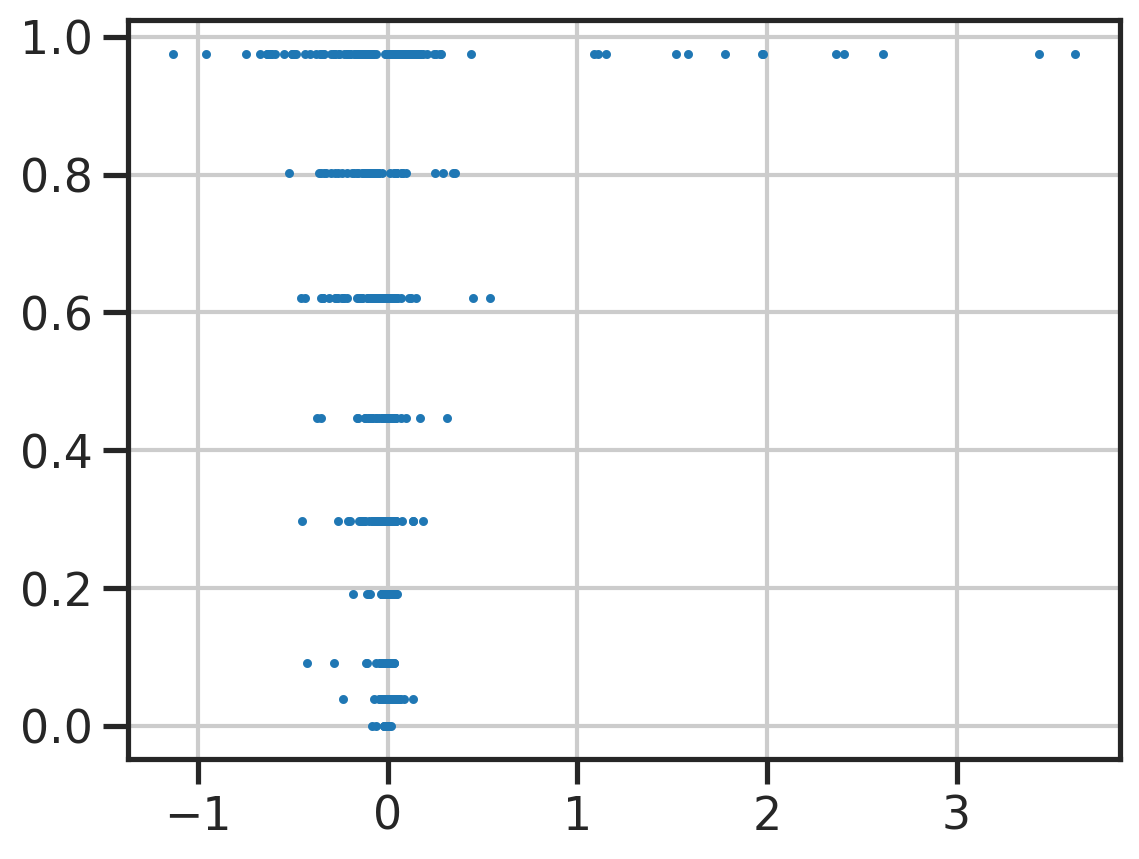

In [27]:
plt.scatter(mlfc, -np.log10(qs), s=3)

In [28]:
upgenes = np.sort(genes[mlfc > 1]) 
len(upgenes), upgenes

(13,
 array(['Arc', 'Egr1', 'Egr2', 'Egr4', 'Fos', 'Fosb', 'Fosl2', 'Jun',
        'Junb', 'Nr4a1', 'Nr4a2', 'Nr4a3', 'Per1'], dtype=object))

In [29]:
genes[mlfc < -1]

array(['Lamp5'], dtype=object)

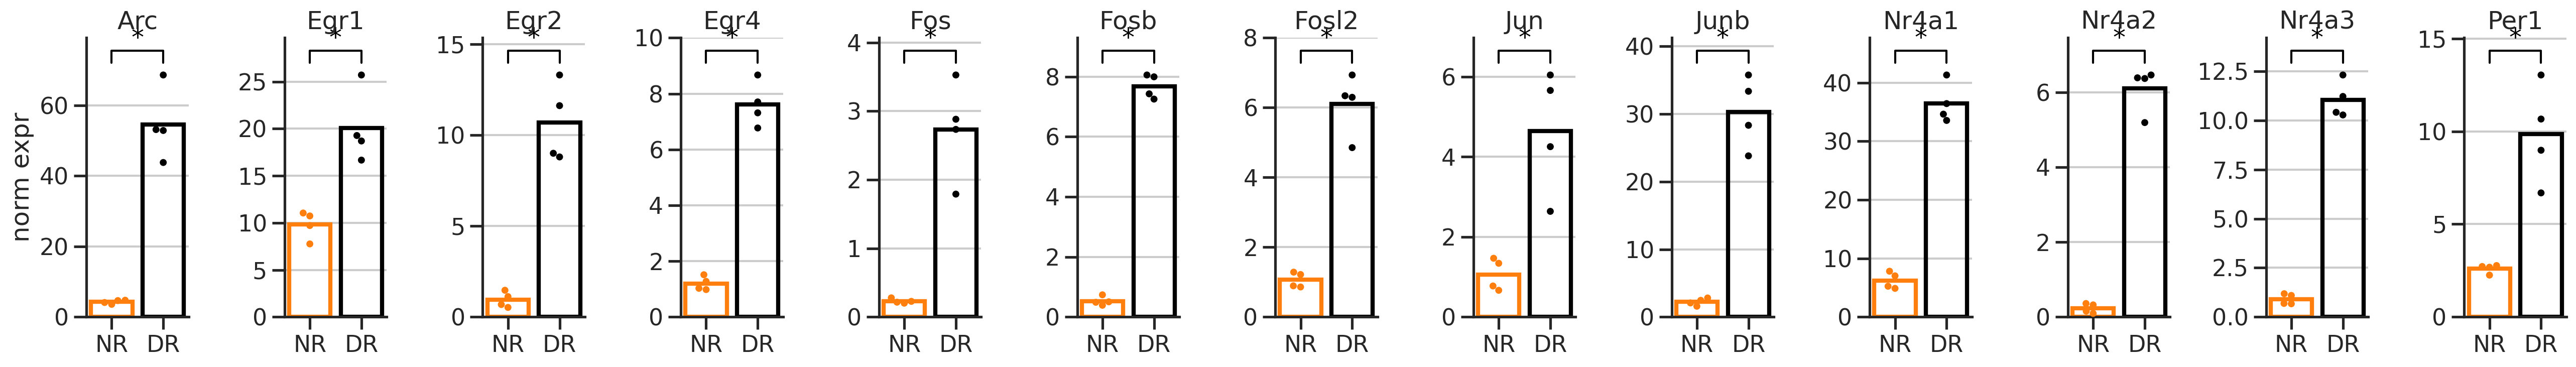

In [30]:
target_genes = np.sort(genes[mlfc > 1])
n = len(target_genes) 

fig, axs = plt.subplots(1, n, figsize=(2*n,4))
for gn, ax in zip(target_genes, axs):
    check_gene(adata, gn, ax)
    ax.set_ylabel('')
    
axs[0].set_ylabel('norm expr')
fig.tight_layout()
plt.show()

# cell level

In [31]:
gnr = np.array(adata[adata.obs['sample'].str.contains('NR')].layers['ljnorm'])
gdr = np.array(adata[adata.obs['sample'].str.contains('DR')].layers['ljnorm'])
    
mlfc2 = np.mean(gdr, axis=0) - np.mean(gnr, axis=0)
ss, ps = stats.mannwhitneyu(gnr, gdr)
rej, qs, _, _ = multipletests(ps, method='fdr_bh')

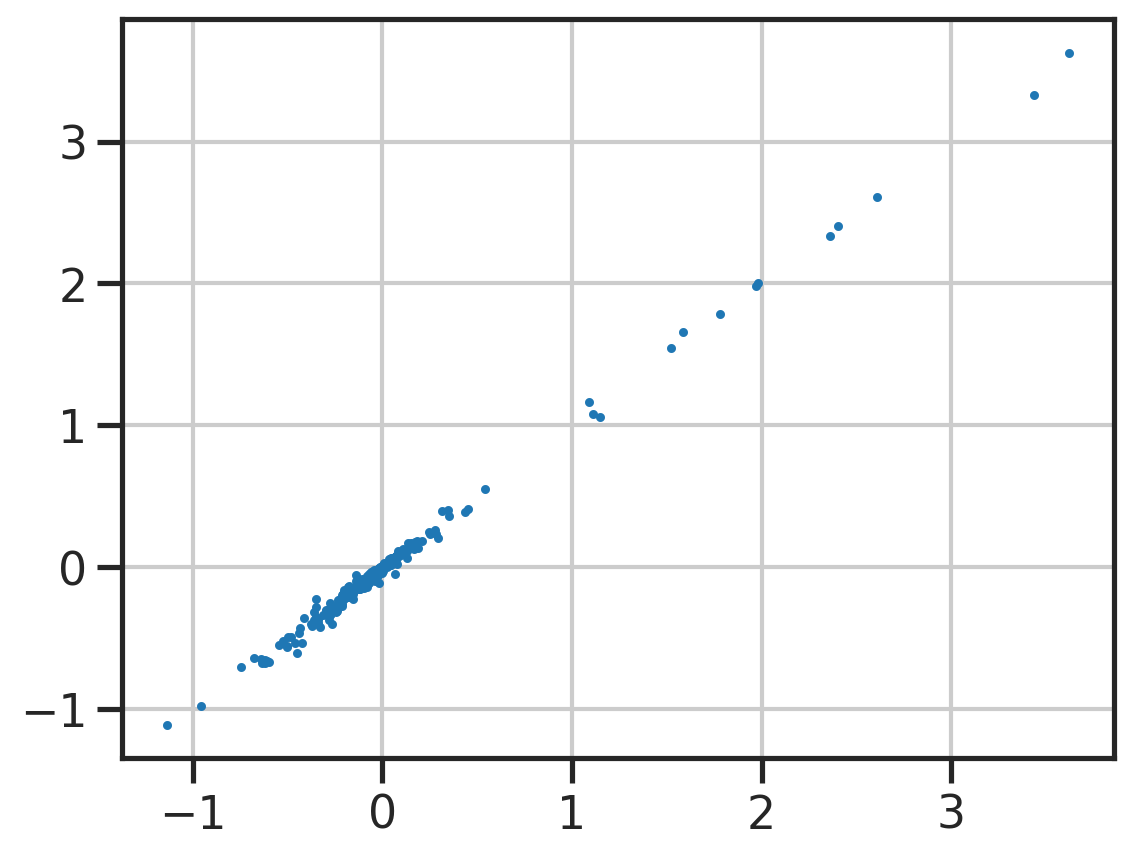

In [32]:
plt.scatter(mlfc, mlfc2, s=3)

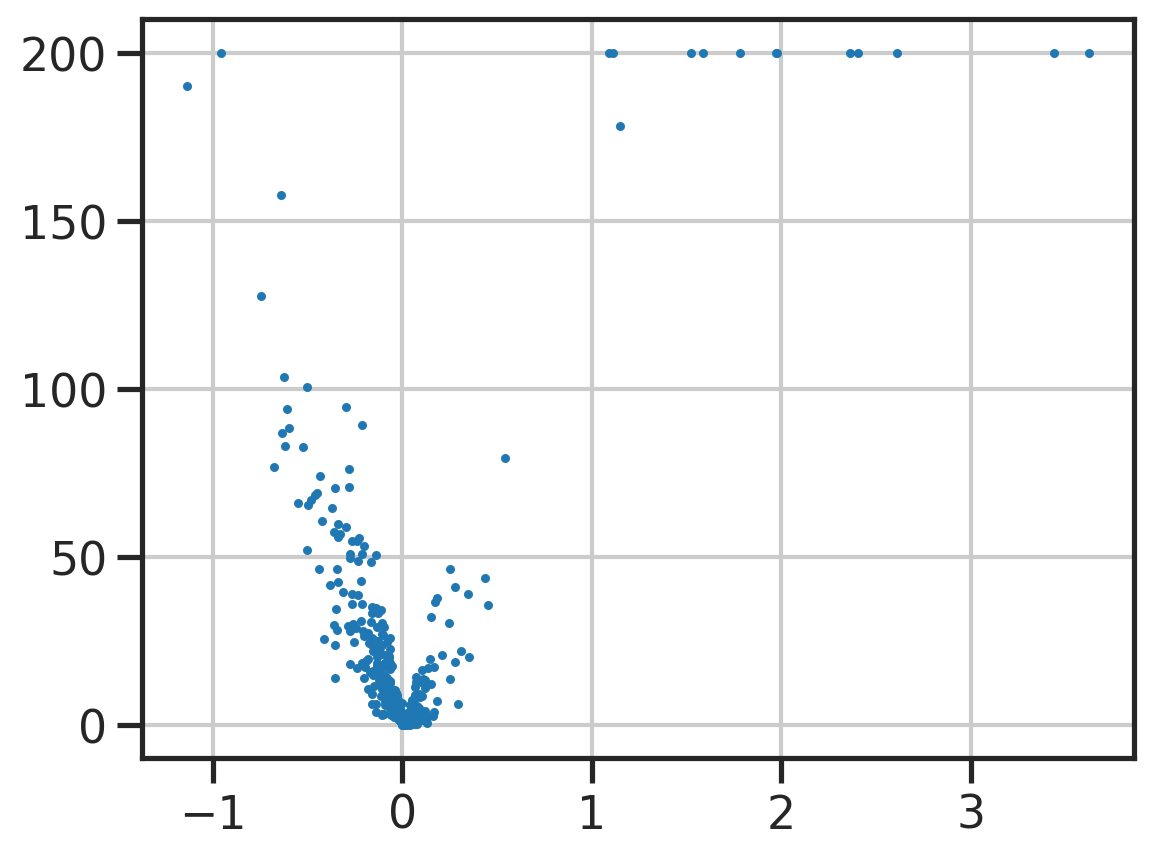

In [33]:
plt.scatter(mlfc, -np.log10(qs+1e-200), s=3)

In [34]:
upgenes = np.sort(genes[mlfc > 1]) 
len(upgenes), upgenes

(13,
 array(['Arc', 'Egr1', 'Egr2', 'Egr4', 'Fos', 'Fosb', 'Fosl2', 'Jun',
        'Junb', 'Nr4a1', 'Nr4a2', 'Nr4a3', 'Per1'], dtype=object))

In [35]:
genes[mlfc < -1]

array(['Lamp5'], dtype=object)

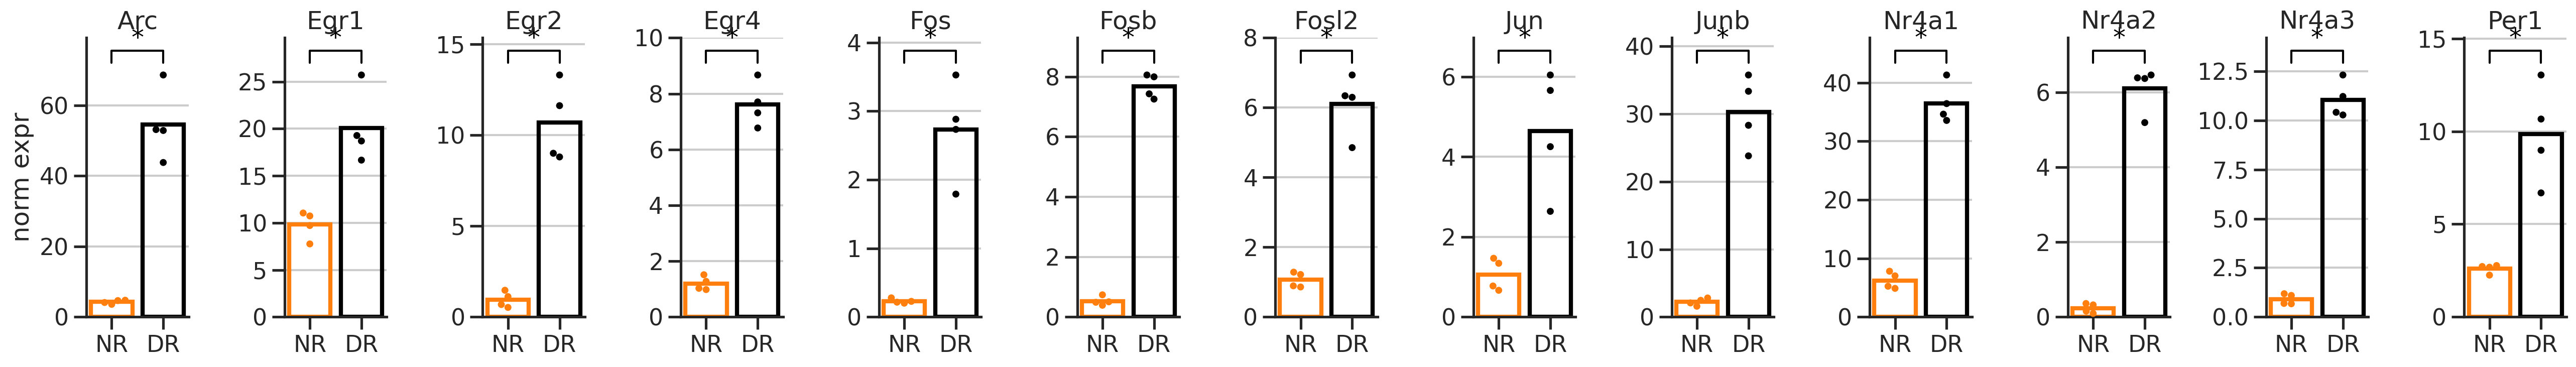

In [36]:
target_genes = np.sort(genes[mlfc > 1])
n = len(target_genes) 

fig, axs = plt.subplots(1, n, figsize=(2*n,4))
for gn, ax in zip(target_genes, axs):
    check_gene(adata, gn, ax)
    ax.set_ylabel('')
    
axs[0].set_ylabel('norm expr')
fig.tight_layout()
plt.show()

# check iegs

In [46]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/Hrvatin17_ARGs.csv'
hr_args = pd.read_csv(f, skiprows=6, index_col=0) #[0].values
hr_iegs = hr_args[np.any(hr_args=='a', axis=1)]

hrl23_args = hr_args[~hr_args['ExcL23'].isnull()]
hrl23_iegs = hr_args[hr_args['ExcL23'].isin(['a', ])]
hrl23_lrgs = hr_args[hr_args['ExcL23'].isin(['c', 'd'])]

print(len(hrl23_args))
print(len(hrl23_iegs))
print(len(hrl23_lrgs))

79
42
37


In [38]:
hr_args

,ExcL23,ExcL4,ExcL5_3,ExcL5_2,ExcL5_1,ExcL6,Int_Pv,Int_Vip,Int_Sst_1,Int_Sst_2,...,Endo_2,SM_1,SM_2,Micro_1,Micro_2,Macrophage,Pericyte,Ensembl,TF,secreted
Gene Name,,,,,,,,,,,,,,,,,,,,,
Arc,a,a,a,a,a,a,NaN,NaN,NaN,a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSMUSG00000022602,0,0
Arl4d,a,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSMUSG00000034936,0,0
Arl5b,a,a,NaN,NaN,a,a,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSMUSG00000017418,0,0
Bdnf,c,c,c,c,c,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSMUSG00000048482,0,1
Cdc42ep3,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSMUSG00000036533,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Snhg11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,d,ENSMUSG00000044349,0,0
Spp1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,c,ENSMUSG00000029304,0,1
Tmem9b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,c,ENSMUSG00000031021,0,0


,ExcL23,ExcL4,ExcL5_3,ExcL5_2,ExcL5_1,ExcL6,Int_Pv,Int_Vip,Int_Sst_1,Int_Sst_2,...,Endo_2,SM_1,SM_2,Micro_1,Micro_2,Macrophage,Pericyte,Ensembl,TF,secreted
Gene Name,,,,,,,,,,,,,,,,,,,,,
Arc,a,a,a,a,a,a,NaN,NaN,NaN,a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSMUSG00000022602,0,0
Arl4d,a,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSMUSG00000034936,0,0
Arl5b,a,a,NaN,NaN,a,a,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSMUSG00000017418,0,0
Cdc42ep3,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSMUSG00000036533,0,0
Cdkn1a,c,c,c,NaN,c,c,NaN,NaN,NaN,a,...,NaN,NaN,a,NaN,NaN,NaN,NaN,ENSMUSG00000023067,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fam107b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,a,ENSMUSG00000026655,0,0
Odc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,a,ENSMUSG00000011179,0,0
Pde4b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,d,NaN,NaN,NaN,NaN,a,ENSMUSG00000028525,0,0


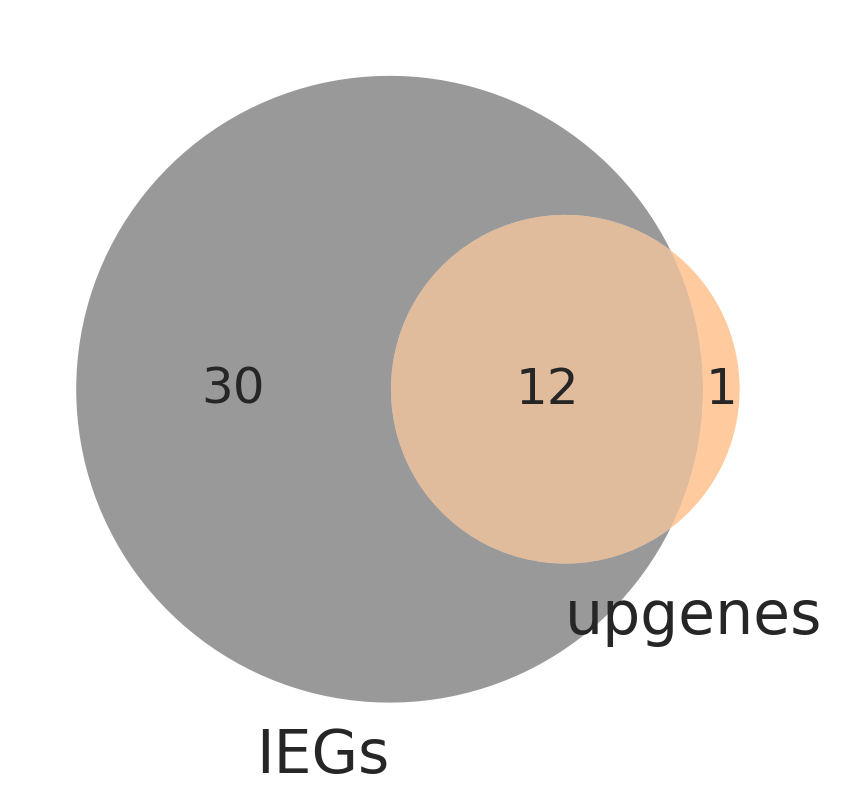

In [39]:
from matplotlib_venn import venn2

fig, ax = plt.subplots()
a = hrl23_iegs.index.values
b = upgenes
venn2([set(a.tolist()), set(b.tolist())], 
      set_labels=('IEGs', 'upgenes'), 
      set_colors=('k', 'C1'),
      ax=ax,
     )
# output = os.path.join(outfigdir, "venn_diagram.pdf")
# powerplots.savefig_autodate(fig, output)
plt.show()

In [40]:
[g for g in b if g not in a]

['Jun']

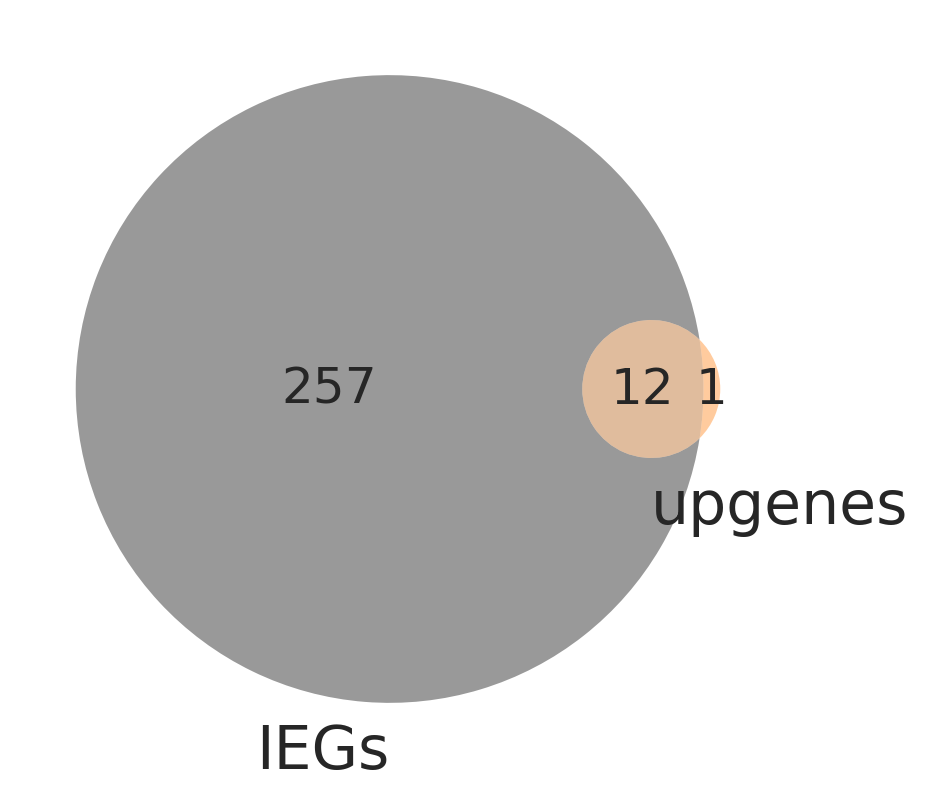

In [47]:
fig, ax = plt.subplots()
a = hr_iegs.index.values
b = upgenes
venn2([set(a.tolist()), set(b.tolist())], 
      set_labels=('IEGs', 'upgenes'), 
      set_colors=('k', 'C1'),
      ax=ax,
     )
# output = os.path.join(outfigdir, "venn_diagram.pdf")
# powerplots.savefig_autodate(fig, output)
plt.show()